In [20]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [21]:
path = "C:/Users/74279/PycharmProjects/NBA2K-Ratings/Data/"

In [22]:
stats = pd.read_csv(path+'2015-2022 NBA Player Stats.csv')
stats = stats.iloc[:,1:]
stats = stats[stats.GP > 41]

In [23]:
x = stats.iloc[:,5:22]
x = x.drop(["MPG","MIN"],axis=1)
y = stats.iloc[:,-1:]
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=671)

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(criterion='mae',random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mae',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [27]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [28]:
base_model = RandomForestRegressor(n_estimators = 100, random_state = 42)
base_model.fit(x_train,y_train)
print(base_model.score(x_test,y_test))
best_random = rf_random.best_estimator_
print(best_random.score(x_test,y_test))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0.8846452626762887
0.8853337921098944


In [29]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [30]:
# Fit the grid search to the data
grid_search.fit(x_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [31]:
best_grid = grid_search.best_estimator_
print(mae(best_grid.predict(x_train),y_train))
print(mae(best_grid.predict(x_test),y_test))

0.8812490199141739
1.420079794007522


In [32]:
x_train = pd.DataFrame(x_train)
x_train.columns = x.columns
explainer = shap.Explainer(best_grid,x_train)
shap_values = explainer(x_train)

 99%|===================| 1498/1506 [03:07<00:00]        

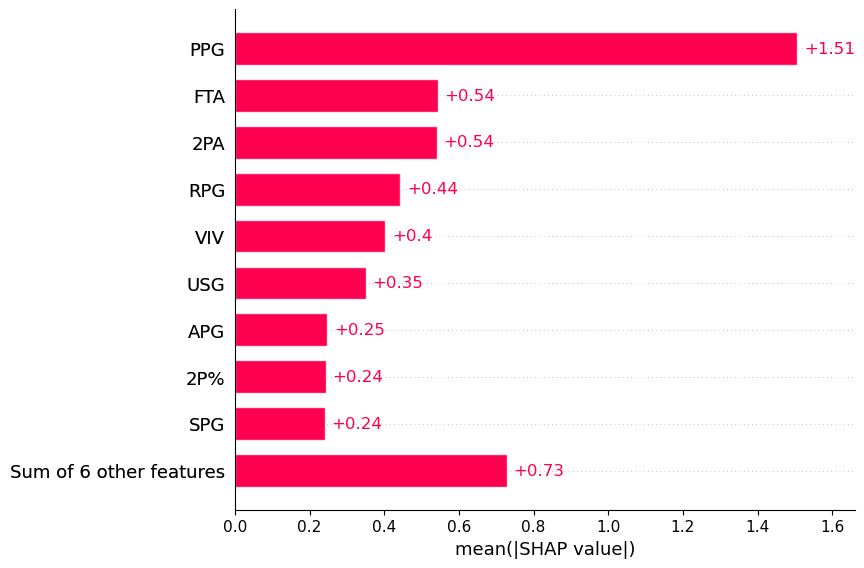

In [33]:
shap.plots.bar(shap_values)